# Resampling in the sinogram space

https://arxiv.org/pdf/1708.05163.pdf

https://github.com/tsiper/sampl-ct/blob/master/Interpolation/SinogramKernel.m

In [117]:
import numpy as np
import scipy.fft as fft
import matplotlib.pyplot as plt

In [118]:
"""
The functions of this cell are mostly copy pasted from their matlab code.
"""

def hamming_window(ts, thetas, window_size):
    t_grid, theta_grid = np.meshgrid(ts, thetas)
    r = np.sqrt(t_grid ** 2 + (theta_grid / np.pi) ** 2)
    w = np.zeros_like(r)
    w[r < window_size / 2] = 0.54 + 0.46 * np.cos(2 * np.pi * r[r < window_size / 2] / window_size)
    return w

def sinogram_kernel(ts, thetas, B, R, W):

    t_grid, theta_grid = np.meshgrid(ts, thetas)
    res = np.zeros_like(t_grid)

    def aux1(mask, t, theta):
        a = (np.cos(W * t - theta * (B + R * W)) - np.cos(B * theta)) / (t - theta * R)
        b = (np.cos(W * t + theta * (B + R * W)) - np.cos(B * theta)) / (t + theta * R)
        res[mask] = (a - b) / (np.pi * theta)

    def aux2(mask, theta):
        res[mask] = (2 * theta * R * W * np.sin(theta * B) + np.cos(theta * B) - np.cos(theta * (B + 2 * R * W))) / (2 * np.pi * R * theta**2)

    def aux3(mask, t):
        res[mask] = (2 * t * np.sin(W * t) * (B + R * W) + 2 * R * (np.cos(W * t) - 1)) / (np.pi * t**2)

    def aux4(mask):
        res[mask] = 2 / np.pi * W * (B + (R * W) / 2)

    mask1 = (theta_grid == 0)
    mask2 = (t_grid == 0)
    mask3 = (abs(t_grid) - abs(theta_grid * R)) == 0
    aux4(mask1 & mask2)
    aux3(mask1 & (~mask2), t_grid[mask1 & (~mask2)])
    aux2(~mask1 & mask3, theta_grid[~mask1 & mask3])
    aux1(~mask1 & ~mask3, t_grid[~mask1 & ~mask3], theta_grid[~mask1 & ~mask3])

    return res

def old_sinogram_kernel(ts, thetas, B, R, W):

    def aux(t, theta):

        if theta == 0:
            if t == 0:
                return 2 / np.pi * W * (B + (R * W) / 2)
            else:
                return (2 * t * np.sin(W * t) * (B + R * W) + 2 * R * (np.cos(W * t) - 1)) / (np.pi * t**2)
        
        elif abs(t) == abs(theta * R):
            return (2 * theta * R * W * np.sin(theta * B) + np.cos(theta * B) - np.cos(theta * (B + 2 * R * W))) / (2 * np.pi * R * theta**2)
        
        else:
            v1 = (np.cos(W * t - theta * (B + R * W)) - np.cos(B * theta)) / (t - theta * R)
            v2 = (np.cos(W * t + theta * (B + R * W)) - np.cos(B * theta)) / (t + theta * R)
            return (v1 - v2) / (np.pi * theta)


    a = np.zeros(shape=(len(thetas), len(ts)))

    for i, theta in enumerate(thetas):
        for j, t in enumerate(ts):
            a[i, j] = aux(t, theta)

    return a

# Test

In [119]:
from silx.image.projection import Projection

from ppfft.tools.phantom_generator import generate_phantom
from ppfft.tools.grids import domain

In [120]:
n = 1024
B = (2 * n + 2) // 8 
R = 1 / (np.sqrt(2) * np.pi)
W = np.pi * n
window_size = 8

ts = np.linspace(-0.5, 0.5, num=n)
# thetas = np.linspace(-np.pi / 2, np.pi / 2, num=n)
thetas = np.linspace(-np.pi/4, 3*np.pi/4, num=n)

h_full = sinogram_kernel(ts, thetas, B, R, W)
window = hamming_window(ts, thetas, 2 * window_size / n)
h_window = window * h_full
h_window /= np.sum(h_window)

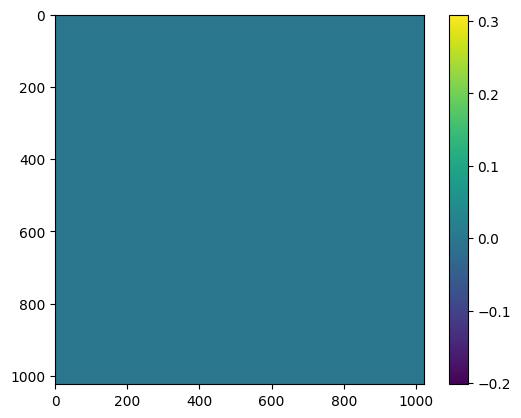

In [121]:
plt.imshow(h_window)
plt.colorbar()

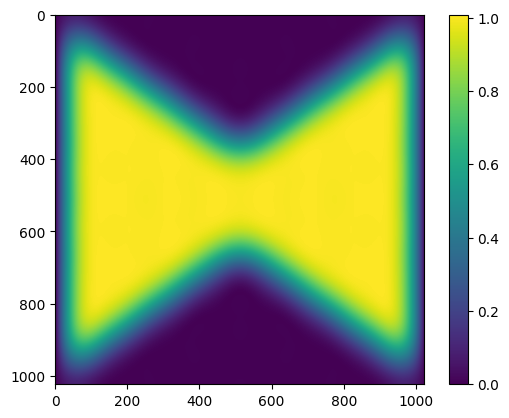

In [122]:
plt.imshow(fft.fftshift(np.abs(fft.fft2(h_window))))
plt.colorbar()

In [123]:
def compute_b(sinogram, q, reg=1e-6):
    fft2_sino = fft.fft2(sinogram)
    fft2_q = np.abs(fft.fft2(q))
    res = fft.ifft2(fft2_q * fft2_sino / (fft2_q ** 2 + reg))
    return res.real

In [124]:
from scipy.signal import fftconvolve

In [125]:
im = generate_phantom(n)
proj = Projection(im.shape, thetas)
sinogram = proj.projection(im)

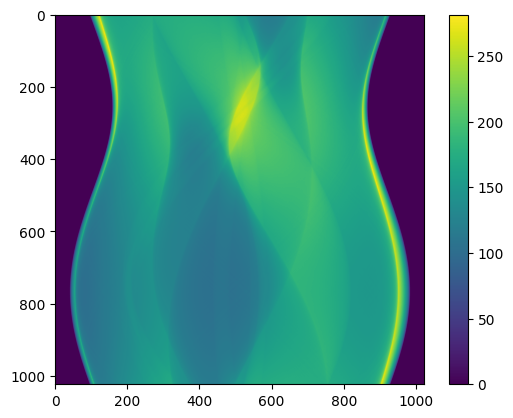

In [126]:
plt.imshow(sinogram)
plt.colorbar()

In [127]:
b = compute_b(sinogram, h_window, 1e-3)

In [128]:
res = fftconvolve(b, h_window)

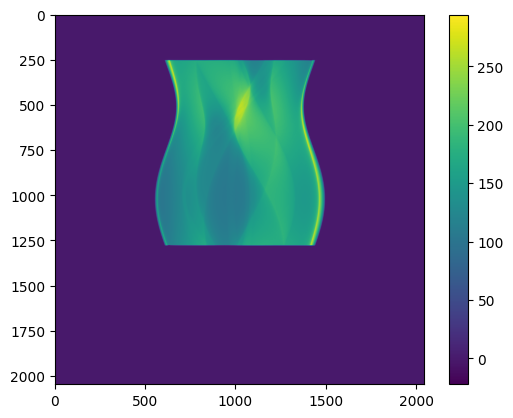

In [129]:
plt.imshow(res)
plt.colorbar()

In [130]:
from silx.opencl.backprojection import Backprojection

In [ ]:
B = Backprojection()

In [14]:
from ppfft.ppfft.new_ppfft import new_ppfft

In [15]:
n = 500
im = generate_phantom(n)

In [16]:
hori, vert = new_ppfft(im)

In [17]:
ifft_hori = fft.irfft(hori, axis=0)
ifft_vert = fft.irfft(vert, axis=0)

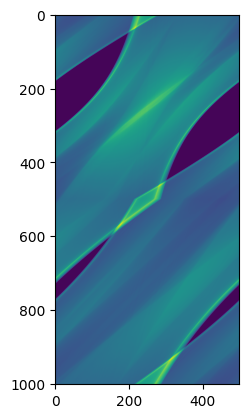

In [18]:
sino_from_ppfft = np.concatenate((ifft_hori.T, ifft_vert[::-1, ::-1].T), axis=0)
plt.imshow(sino_from_ppfft)

It seems this is a sort of aliased Radon transform. This is coherent with the original paper on the PP transform, which oversampled the Fourier domain by a factor 2, to enable a Radon transform. However, it looks very different from what we are supposed to reproduce, so we don't think it will work with this convention for the PPFFT. We try going back to the old one.

# Original PPFFT and corresponding Radon transform

In [19]:
from ppfft.legacy.ppfft import ppfft as old_ppfft
from ppfft.legacy.fast_direct_inverse import fast_direct_inversion, precompute_all
from ppfft.tools.new_fft import new_ifft

In [20]:
def old_radon_transform(im):
    """l = np.arange(-(n//2), n//2 + 1)
    Theta2 = np.arctan(2 * l / n) # from 3pi/4 to pi/4 (decreasing)
    Theta1 = np.pi / 2 - Theta2 # from -pi/4 to pi/4 (increasing)"""
    hori, vert = old_ppfft(im)
    fft_hori = new_ifft(hori.T, axis=0)
    fft_vert = new_ifft(vert.T, axis=0)

    return np.concatenate((fft_hori, fft_vert[::-1, ::-1]), axis=1).real


def old_ppfft_from_old_radon(sino):
    n = sino.shape[0] // 2
    fft_hori, fft_vert = sino[:, :n+1], sino[:, n+1:][::-1, ::-1]
    hori, vert = new_fft(fft_hori, axis=0), new_fft(fft_vert, axis=0)

    return hori.T, vert.T

In [21]:
n = 256
im = generate_phantom(n)

In [22]:
old_radon = old_radon_transform(im)

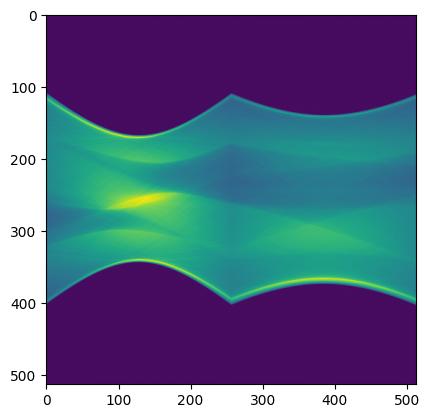

In [23]:
plt.imshow(old_radon)

This uses the new definition, without $m = 2n + 1$.

In [24]:
from ppfft.ppfft import ppfft
from ppfft.tools.new_fft import new_ifft, new_fft

In [25]:
def radon_transform(im):
    hori, vert = ppfft(im)
    fft_hori = new_ifft(hori, axis=0)
    fft_vert = new_ifft(vert, axis=0)

    return np.concatenate((fft_hori, fft_vert[::-1, ::-1]), axis=1).real


def ppfft_from_radon(sino):
    n = sino.shape[0] - 1
    fft_hori, fft_vert = sino[:, :n+1], sino[:, n+1:][::-1, ::-1]
    hori, vert = new_fft(fft_hori, axis=0), new_fft(fft_vert, axis=0)

    return hori, vert

In [26]:
radon = radon_transform(im)

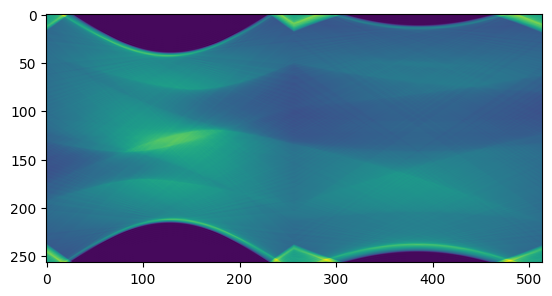

In [27]:
plt.imshow(radon)

We can see that it looks the same, but some parts have been folded onto the real radon transform. We try to reproduce this:

In [28]:
def radon_from_old_radon(old_radon):
    n = old_radon.shape[0] // 2 # old_radon.shape = (2 * n + 1, 2 * n + 2)
    
    res = np.copy(old_radon[n - n//2:n + n//2+1])
    res[:n//2] += old_radon[-(n//2):]
    res[-(n//2):] += old_radon[:n//2]

    return res

In [29]:
old_radon = old_radon_transform(im)
radon = radon_transform(im)
res = radon_from_old_radon(old_radon)

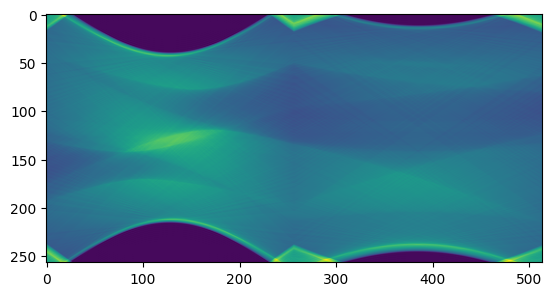

In [30]:
plt.imshow(res)

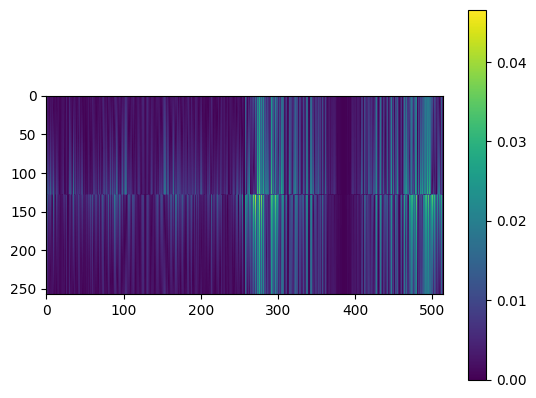

In [31]:
plt.imshow(np.abs(res - radon))
plt.colorbar()

It seems to work. We try an inversion from the folded sinogram:

In [ ]:
from ppfft.inverse.direct_inversion import direct_inversion, precompute_onion_peeling

In [32]:
sol = direct_inversion(*ppfft_from_radon(radon_from_old_radon(old_radon)), precompute_onion_peeling(n))

NameError: name 'direct_inversion' is not defined

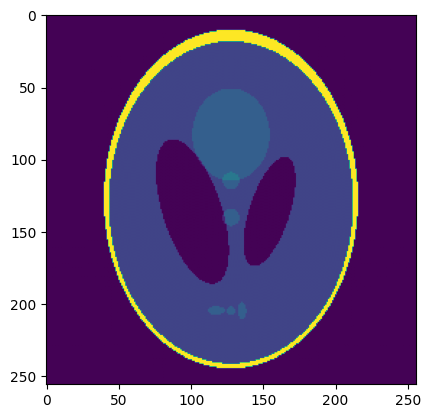

In [222]:
plt.imshow(sol)

In [33]:
def interpolate_sino(thetas, window_size, b, n):
    """
    b is FiltSinogram
    """

    n_theta, n_r = b.shape

    l = np.arange(-(n//2), n//2 + 1)
    thetas_pp = np.concatenate((np.arctan(2 * l / n), np.pi / 2 - np.arctan(2 * l / n)[::-1]))

    pp_sinogram = np.zeros(shape=(2 * n + 2, 2 * n + 1)) # theta, r
    Mpp, Npp = 2 * n + 1, 2 * n + 2

    # Debugging
    
    for l in range(Npp): # theta
        for k in range(Mpp): # r
            
            theta_pp = thetas_pp[l]

            if (theta_pp >= -np.pi / 4) and (theta_pp < np.pi / 4):
                K = k - 1 - Mpp / 2
                T = np.abs(np.cos(theta_pp))
            else:
                K = k - 1 - (Mpp + 2 * (theta_pp - np.pi / 4) / (np.pi / 4)) / 2
                T = np.abs(np.sin(theta_pp))

            I = np.arange(1, n_r + 1) - 1 - (n_r + 1) / 2
            d_theta = theta_pp - thetas
            d_t = (K * T - I) / n_r
            d_t -= abs(np.mod(theta_pp + np.pi / 4, np.pi / 2) - np.pi / 4) / (np.pi * n_r)

            min_theta_idx = np.argmin(np.abs(d_theta))
            min_t_idx = np.argmin(np.abs(d_t))
            delta = int(np.ceil(window_size))

            j = np.arange(-delta, delta + 1) + min_t_idx
            j = j[(j >= 0) & (j < len(d_t))]
            i = np.arange(-delta, delta + 1) + min_theta_idx
            i = i[(i >= 0) & (i < len(d_theta))]
            
            d_Theta, d_T = np.meshgrid(d_theta[i], d_t[j], indexing='ij')
            Rad = np.sqrt(d_T ** 2 + (d_Theta / np.pi) ** 2)
            Window = 0.54 + 0.46 * np.cos(2 * np.pi * Rad / window_size * n)
            Window[Rad >= window_size / (2 * n)] = 0

            h = T * Window * sinogram_kernel(d_t[j], d_theta[i], B, R, W) / np.size(b)

            pp_sinogram[l, k] = np.sum(h * b[np.ix_(i, j)])

    return pp_sinogram

In [322]:
n = 1024
B = (2 * n + 2) // 8 
R = 1 / (np.sqrt(2) * np.pi)
W = np.pi * n
window_size = 8

ts = np.linspace(-0.5, 0.5, num=n)
# thetas = np.linspace(-np.pi / 2, np.pi / 2, num=n)
thetas = np.linspace(-np.pi/4, 3*np.pi/4, num=2*n)

h_full = sinogram_kernel(ts, thetas, B, R, W)
window = hamming_window(ts, thetas, 2 * window_size / n)
h_window = window * h_full
h_window /= np.sum(h_window)

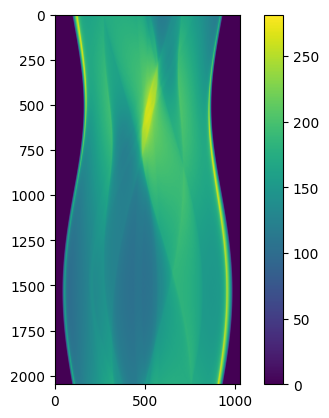

In [323]:
im = generate_phantom(n)
proj = Projection(im.shape, thetas)
sinogram = proj.projection(im)
plt.imshow(sinogram)
plt.colorbar()

In [324]:
b = compute_b(sinogram, h_window, 1e-1)

In [325]:
pp_sino = interpolate_sino(thetas, window_size, b, n)

In [326]:
old_radon = old_radon_transform(im)

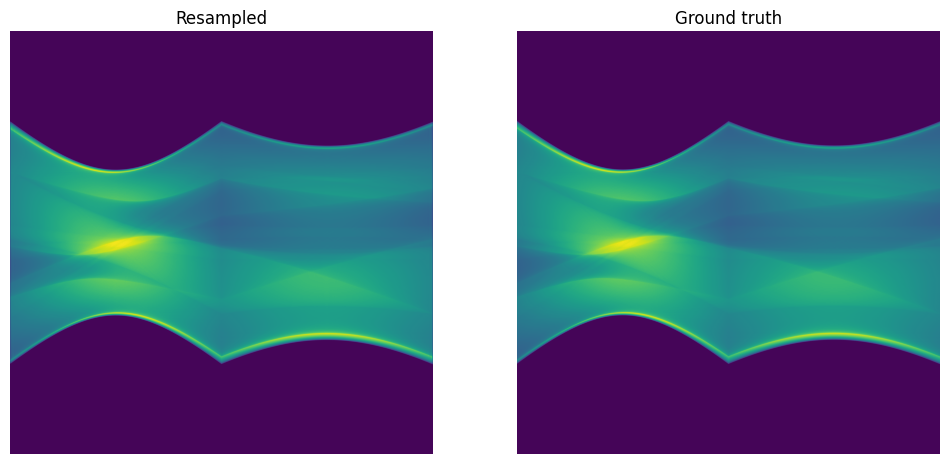

In [327]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(pp_sino.T); axes[0].set_axis_off(); axes[0].set_title("Resampled")
axes[1].imshow(old_radon); axes[1].set_axis_off(); axes[1].set_title("Ground truth")
plt.show()

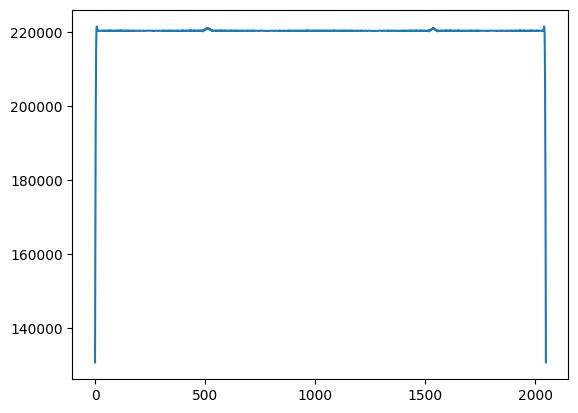

In [328]:
plt.plot(np.sum(pp_sino, axis=1))

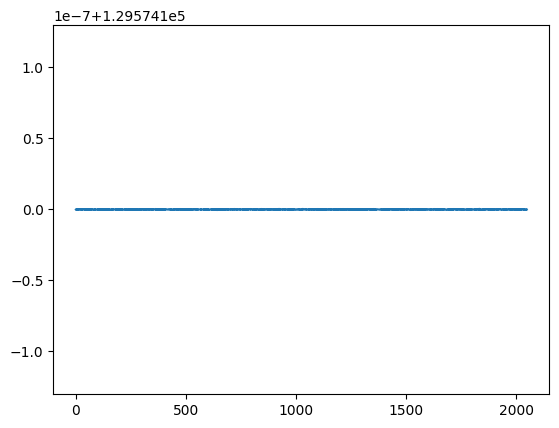

In [329]:
plt.plot(np.sum(old_radon.T, axis=1))

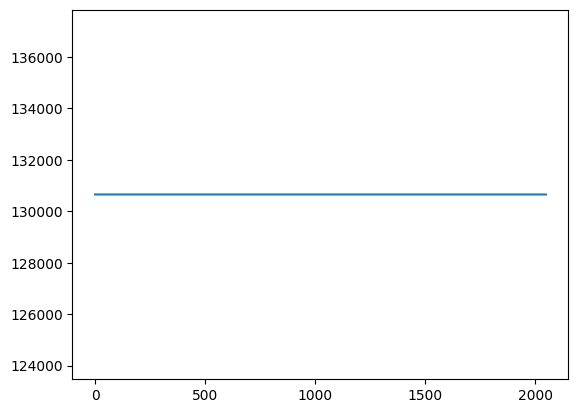

In [330]:
corrected_pp_sino = np.einsum("tr,t->tr", pp_sino, 1 / np.sum(pp_sino, axis=1)) * pp_sino[0].sum()
plt.plot(np.sum(corrected_pp_sino, axis=1))

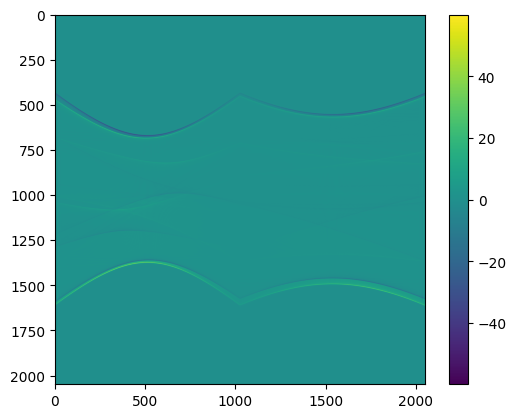

In [331]:
plt.imshow(corrected_pp_sino.T - old_radon)
plt.colorbar()

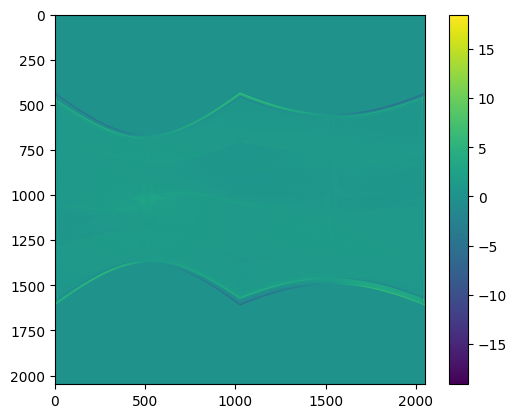

In [332]:
plt.imshow(np.roll(corrected_pp_sino.T, -1, axis=0) - old_radon)
plt.colorbar()

# TO DO

It seems that there is a factor 2 between the true radon and the computed one, EXCEPT for thet first and last projections, which could explain the artifact observed... 

In [333]:
precomputations = precompute_all(n)

h, v = old_ppfft_from_old_radon(corrected_pp_sino.T)
sol1 = fast_direct_inversion(h, v, precomputations)

h, v = old_ppfft_from_old_radon(np.roll(corrected_pp_sino.T, -1, axis=0))
sol2 = fast_direct_inversion(h, v, precomputations)

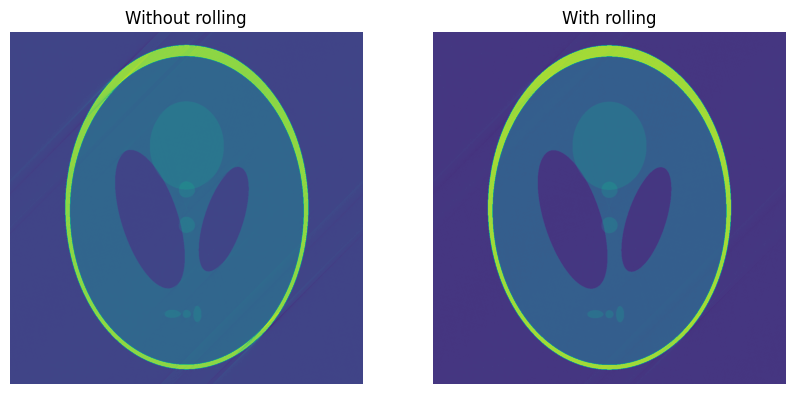

In [334]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(sol1.real); axes[0].set_axis_off(); axes[0].set_title("Without rolling")
axes[1].imshow(sol2.real); axes[1].set_axis_off(); axes[1].set_title("With rolling")
plt.show()

# New convention

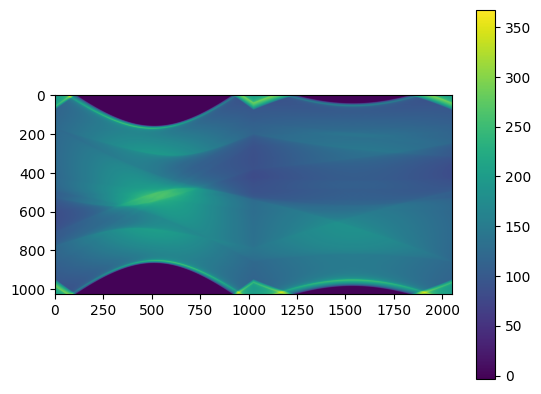

In [335]:
true_pp_radon = radon_transform(im)
plt.imshow(true_pp_radon)
plt.colorbar()

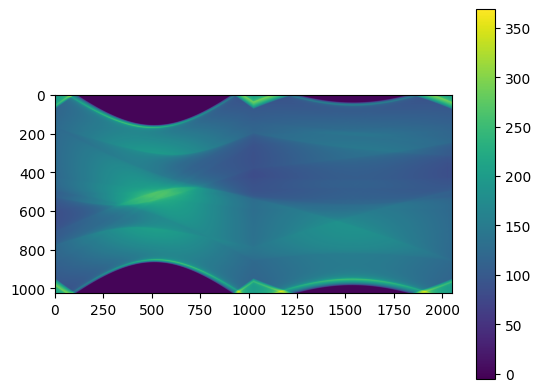

In [336]:
radon = radon_from_old_radon(corrected_pp_sino.T)
plt.imshow(radon)
plt.colorbar()

In [337]:
radon_roll = radon_from_old_radon(np.roll(corrected_pp_sino.T, -1, axis=0))

In [338]:
from ppfft.inverse.direct_inversion import direct_inversion
from ppfft.inverse.onion_peeling import precompute_onion_peeling

In [339]:
precomputations = precompute_onion_peeling(n)

hori, vert = ppfft_from_radon(radon)
sol3 = direct_inversion(hori, vert, precomputations)

hori, vert = ppfft_from_radon(radon_roll)
sol4 = direct_inversion(hori, vert, precomputations)

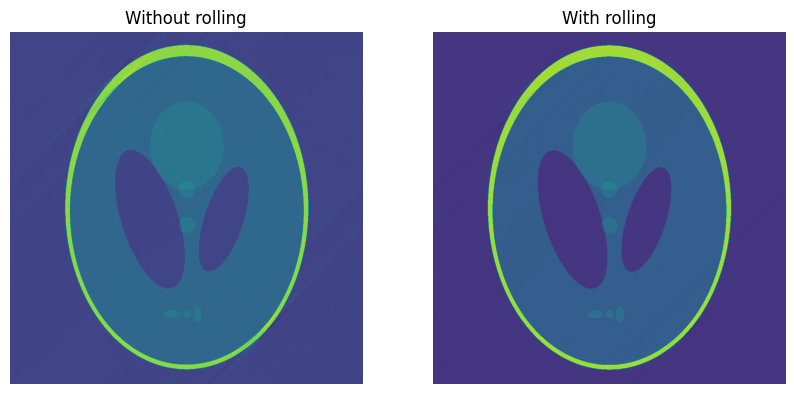

In [340]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(sol3.real); axes[0].set_axis_off(); axes[0].set_title("Without rolling")
axes[1].imshow(sol4.real); axes[1].set_axis_off(); axes[1].set_title("With rolling")
plt.show()

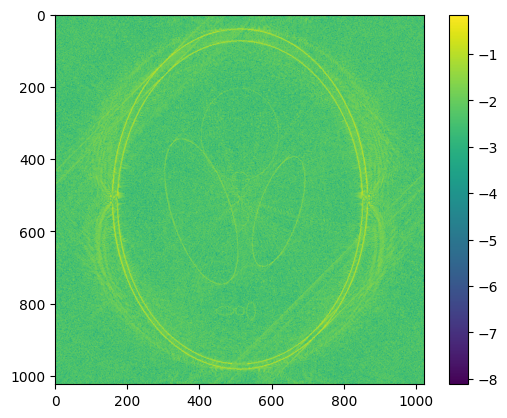

In [349]:
plt.imshow(np.log10(np.abs(sol4 - im)))
plt.colorbar()

In [350]:
def interpolate_sino_new(thetas, window_size, b, n):
    """
    b is FiltSinogram
    """

    n_theta, n_r = b.shape

    l = np.arange(-(n//2), n//2 + 1)
    thetas_pp = np.concatenate((np.arctan(2 * l / n), np.pi / 2 - np.arctan(2 * l / n)[::-1]))

    pp_sinogram = np.zeros(shape=(2 * n + 2, 2 * n + 1)) # theta, r
    Mpp, Npp = 2 * n + 1, 2 * n + 2

    # Debugging
    
    for l in range(Npp): # theta
        for k in range(Mpp): # r
            
            theta_pp = thetas_pp[l]

            if (theta_pp >= -np.pi / 4) and (theta_pp < np.pi / 4):
                K = k - 1 - Mpp / 2
                T = np.abs(np.cos(theta_pp))
            else:
                K = k - 1 - (Mpp + 2 * (theta_pp - np.pi / 4) / (np.pi / 4)) / 2
                T = np.abs(np.sin(theta_pp))

            I = np.arange(1, n_r + 1) - 1 - (n_r + 1) / 2
            d_theta = theta_pp - thetas
            d_t = (K * T - I) / n_r
            
            # d_t -= abs(np.mod(theta_pp + np.pi / 4, np.pi / 2) - np.pi / 4) / (np.pi * n_r)

            min_theta_idx = np.argmin(np.abs(d_theta))
            min_t_idx = np.argmin(np.abs(d_t))
            delta = int(np.ceil(window_size))

            j = np.arange(-delta, delta + 1) + min_t_idx
            j = j[(j >= 0) & (j < len(d_t))]
            i = np.arange(-delta, delta + 1) + min_theta_idx
            i = i[(i >= 0) & (i < len(d_theta))]
            
            d_Theta, d_T = np.meshgrid(d_theta[i], d_t[j], indexing='ij')
            Rad = np.sqrt(d_T ** 2 + (d_Theta / np.pi) ** 2)
            Window = 0.54 + 0.46 * np.cos(2 * np.pi * Rad / window_size * n)
            Window[Rad >= window_size / (2 * n)] = 0

            h = T * Window * sinogram_kernel(d_t[j], d_theta[i], B, R, W) / np.size(b)

            pp_sinogram[l, k] = np.sum(h * b[np.ix_(i, j)])

    return pp_sinogram

In [351]:
n = 1024
B = (2 * n + 2) // 8 
R = 1 / (np.sqrt(2) * np.pi)
W = np.pi * n
window_size = 8

ts = np.linspace(-0.5, 0.5, num=n)
# thetas = np.linspace(-np.pi / 2, np.pi / 2, num=n)
thetas = np.linspace(-np.pi/4, 3*np.pi/4, num=2*n)

h_full = sinogram_kernel(ts, thetas, B, R, W)
window = hamming_window(ts, thetas, 2 * window_size / n)
h_window = window * h_full
h_window /= np.sum(h_window)

In [352]:
im = generate_phantom(n)
proj = Projection(im.shape, thetas)
sinogram = proj.projection(im)

In [353]:
new_b = compute_b(sinogram, h_window, 1e-1)

In [355]:
new_pp_sino = interpolate_sino_new(thetas, window_size, new_b, n)

In [356]:
new_corrected_pp_sino = np.einsum("tr,t->tr", new_pp_sino, 1 / np.sum(new_pp_sino, axis=1)) * new_pp_sino[0].sum()

In [359]:
new_radon = radon_from_old_radon(new_corrected_pp_sino.T)

In [360]:
hori, vert = ppfft_from_radon(new_radon)
sol5 = direct_inversion(hori, vert, precomputations)

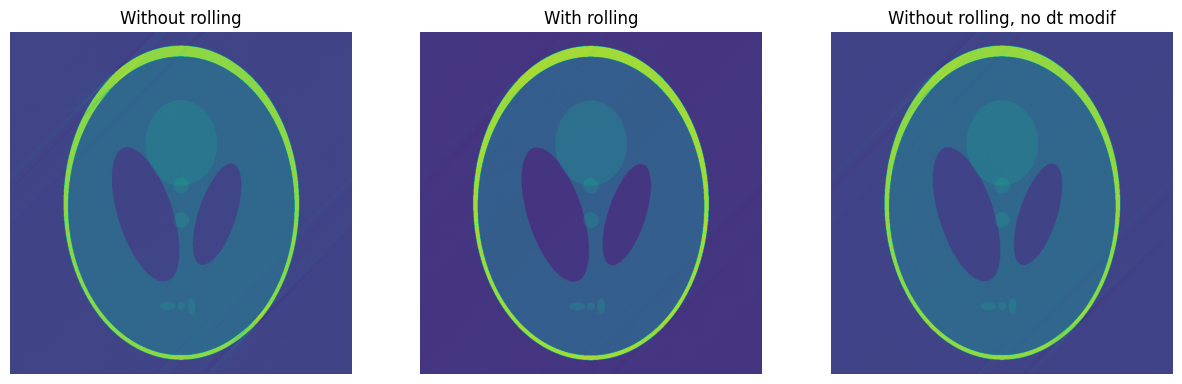

In [362]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(sol3.real); axes[0].set_axis_off(); axes[0].set_title("Without rolling")
axes[1].imshow(sol4.real); axes[1].set_axis_off(); axes[1].set_title("With rolling")
axes[2].imshow(sol5); axes[2].set_axis_off(); axes[2].set_title("Without rolling, no dt modif")
plt.show()